# An injection system

We inject a GW150914-like numerical-relativity waveform (SXS:BBH:0305, downloaded from [SXS's Catalog](https://data.black-holes.org/waveforms/index.html)) into LIGO Hanford's designed PSD (from [bilby](https://lscsoft.docs.ligo.org/bilby/)), and then use rational filters to study its ringdown signal.

Here we simply add the signal to noise, instead of going through bilby's functions.

## TODO is make the levels of the colormap constant to see if the variation is actually large

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter
import sys
from scipy.special import logsumexp

### Construct the GW strain from numerical relativity

In [3]:
NRwaveform = qnm_filter.SXSWaveforms(filename="SXS:BBH:1107")
NRwaveform.get_remnant_data()

Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/metadata.json


We focus on $(l=2,m=\pm2)$ harmonics

In [4]:
NRwaveform.import_sxs_data(l=2, m=2, interpolate=True, delta_t=0.05)
NRwaveform.import_sxs_data(l=2, m=-2, interpolate=True, delta_t=0.05)

NRwaveform.pad_data(partition=2, len_pow=1)

Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1107v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5


All SXS waveforms adopt geometric units with $G=c=M_\odot=1$, and normalize distance and time with BBH's total mass. Below we convert the waveform to SI units.

In [200]:
luminous_intensity = 1/factor*440 # in Mpc
bbh_mass = 120/NRwaveform.mf # BBH's total mass
NRwaveform.scale_to_si("padded_data", bbh_mass, luminous_intensity)

### Construct detector noise with `bilby`

In [201]:
sampling_frequency = 16384 # in Hz
duration = 8 # in second

Instantiate a `bilby.gw.detector.Interferometer` class.

In [202]:
bilby_ifo = qnm_filter.set_bilby_predefined_ifo('H1', sampling_frequency, duration, start_time=-duration/2)

<AxesSubplot: >

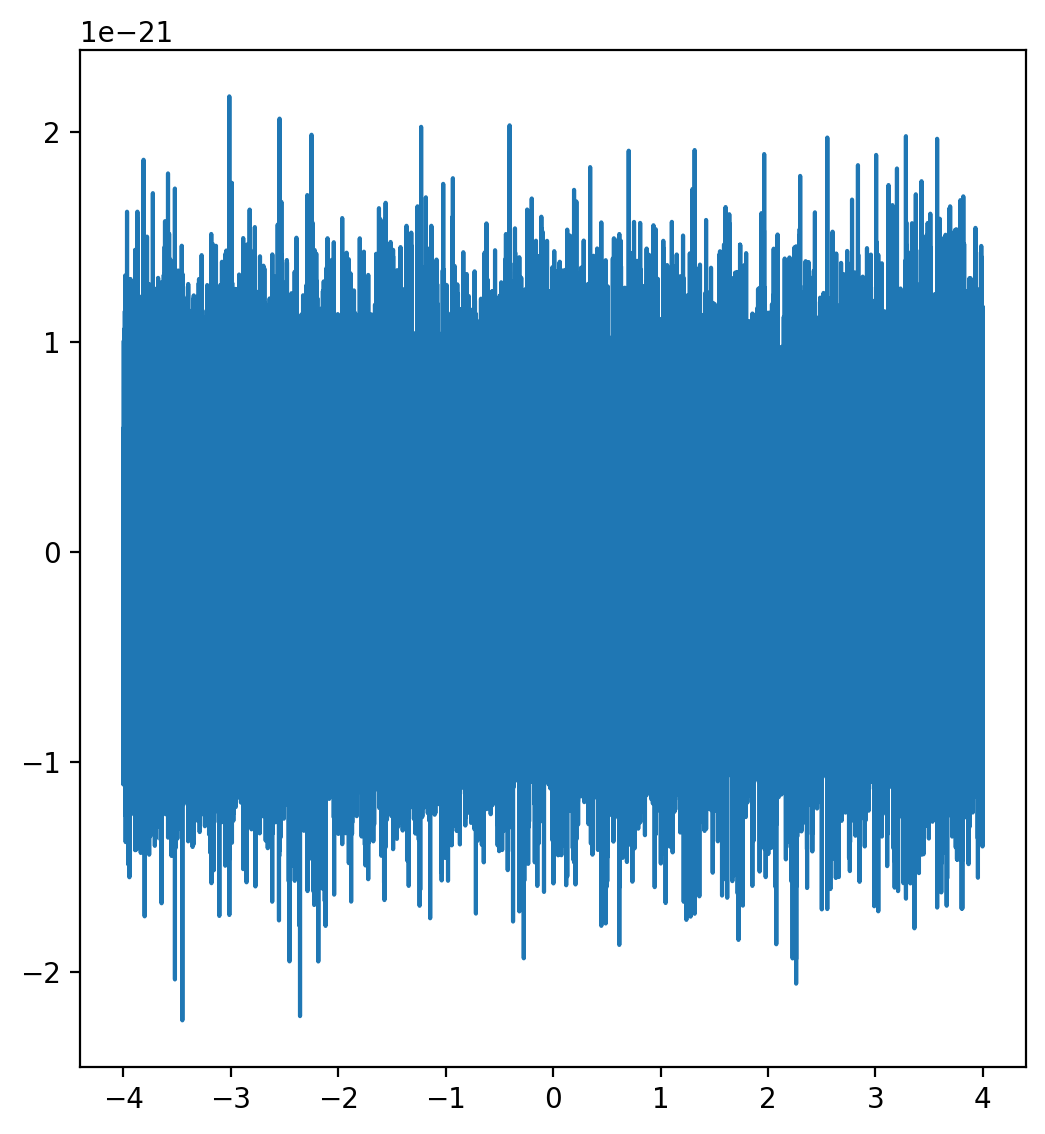

In [203]:
signalH_noise = 2*qnm_filter.bilby_get_strain(bilby_ifo, 0.0)
signalH_noise.plot()

### Inject the GW strain into noise

In [204]:
def get_NR_strain(bilby_ifo, iota, beta, ra, dec, psi):
    """Construct a NR strain
    
    Parameters
    ----------
    bilby_ifo : bilby.gw.detector.Interferometer
        An instance of `bilby.gw.detector.Interferometer`.
    iota : float
        inclination angle in the source frame, in radian.
    beta : float
        azimuth angle in the source frame, in radian.
    ra : float
        right ascension, in radian.
    dec : float
        declination, in radian.
    psi : float
        polarization angle, in radian.
        
    Returns
    -------
    qnm_filter.RealData
        Strain data
    """
    nr_dataset = NRwaveform.harmonics_to_polarizations("data_in_si", iota, beta, [(2,2), (2,-2)])
    hplus = nr_dataset['plus']
    hcross = nr_dataset['cross']
    hplus_interp_func = interp1d(hplus.time, hplus.values, bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(hcross.time, hcross.values, bounds_error=False, fill_value=0)

    time = bilby_ifo.strain_data.time_array
    hplus = hplus_interp_func(time)
    hcross = hcross_interp_func(time)
    
    fp = bilby_ifo.antenna_response(ra, dec, time[0], psi, 'plus')
    fc = bilby_ifo.antenna_response(ra, dec, time[0], psi, 'cross')

    return qnm_filter.RealData(hplus*fp+hcross*fc, index=time, ifo=bilby_ifo.name)

In [205]:
signalH_no_noise = get_NR_strain(bilby_ifo, 0, 0, 0, 0, 0)
signalH = signalH_noise + signalH_no_noise

(-0.1, 0.1)

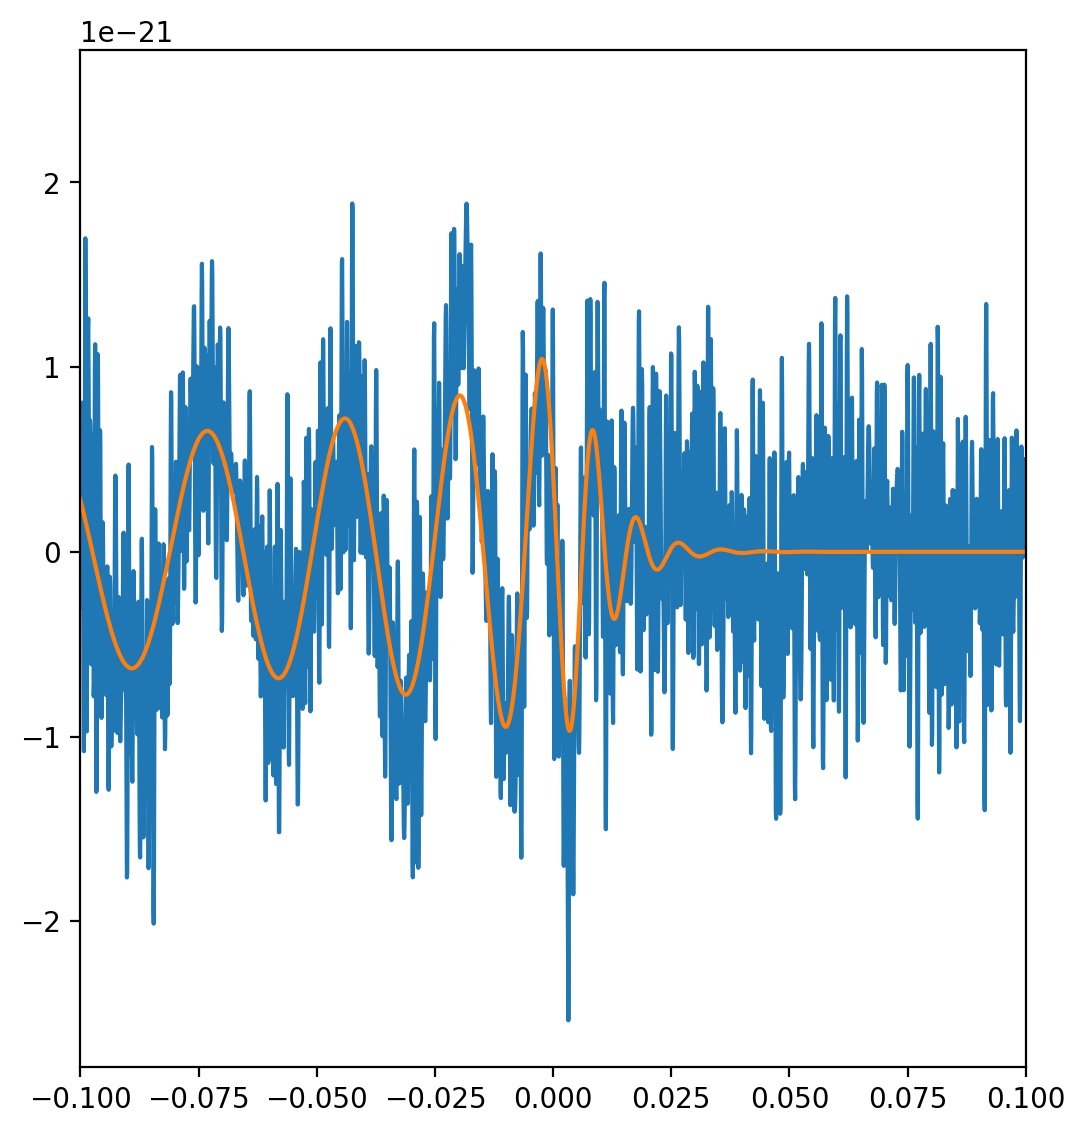

In [206]:
signalH.plot()
signalH_no_noise.plot()
pl.xlim(-0.1,0.1)

### Ringdown analysis with rational filter(s)

In [207]:
inj_mass = NRwaveform.mf*bbh_mass
mass_unit = qnm_filter.Filter.mass_unit(NRwaveform.mf*bbh_mass)

input = dict(model_list = [(2, 2, 0, "p"), (2,2,1,'p'), (2,2,2,'p')\
                           ], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0+0*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 300*mass_unit,
             # sampling rate after conditioning (in Hz)
             srate = 4096)

fit = qnm_filter.Network(**input)

In [208]:
fit.original_data['H1'] = signalH_no_noise
fit.detector_alignment()

We use the Welch method to estimate the covariance matrix with pure noise. The estimation with `original_data` may break down when SNR is large enough

In [209]:
fit.condition_data('original_data')
fit.compute_acfs('original_data')

In [210]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 4*1e-22**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

In [211]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']
fit.compute_SNR(0, template, 'H1', optimal=True)

20.00000000000002

In [199]:
factor = 20/fit.compute_SNR(0, template, 'H1', optimal=True)

Sampling remnant mass and spin

In [212]:
delta_mass = bbh_mass/100
delta_chi = 0.03
massspace = np.arange(0.5*bbh_mass, 2.0*bbh_mass, delta_mass)
temp_massspace = np.arange(0.5, 2.0, 0.01)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)
temp_mass_grid, temp_chi_grid = np.meshgrid(temp_massspace, chispace)

Interate over the samplings

In [213]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                 num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

Plot 2d contours

In [214]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'])/mass_unit, 2))

In [215]:
levels=np.arange(-200, 1, 10)

Text(1.5, 0.1, 'ln(evidence) = 5.58')

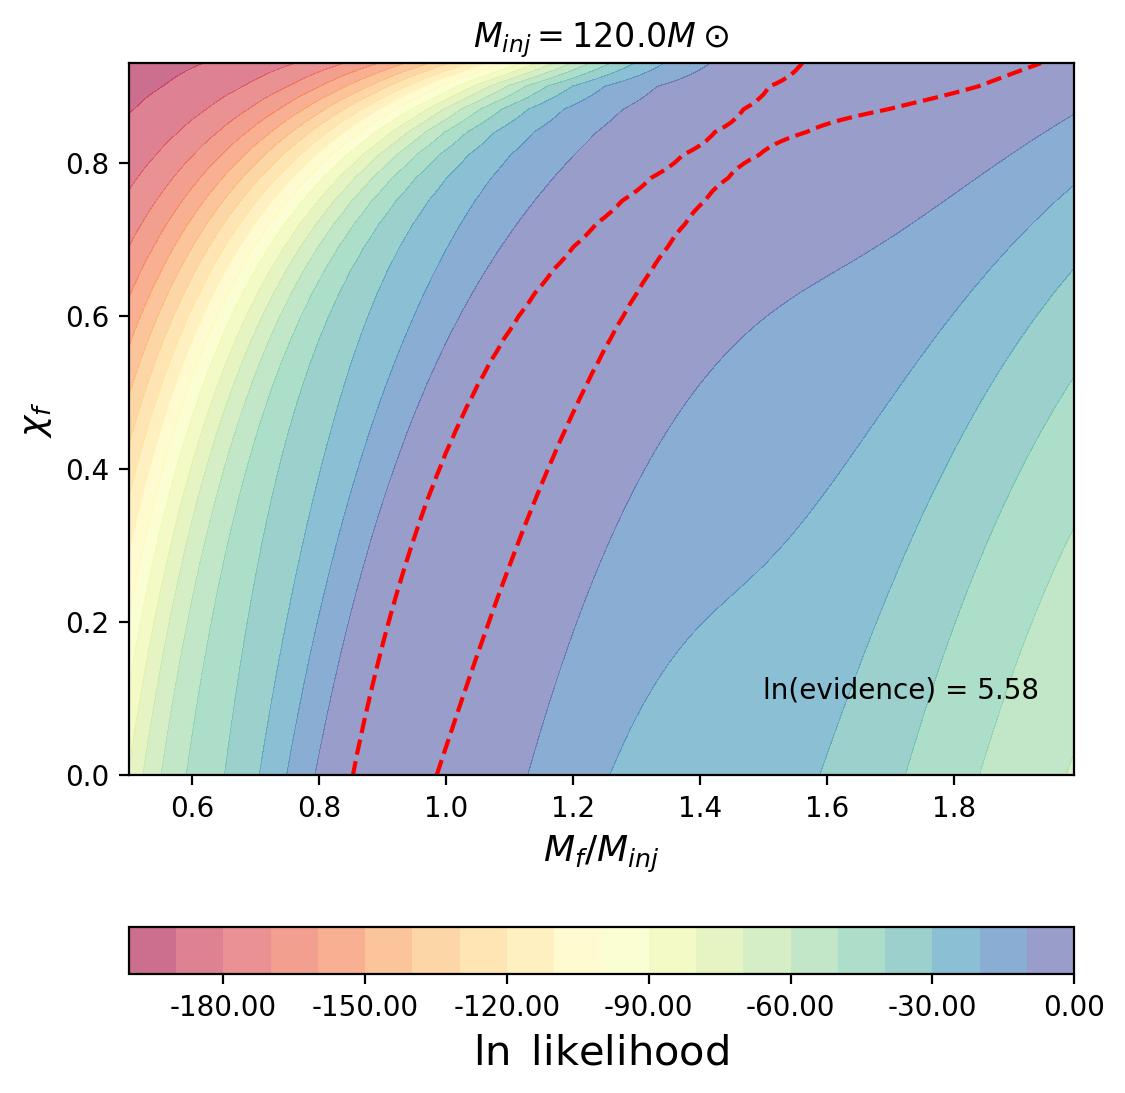

In [216]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(temp_mass_grid, temp_chi_grid, likelihood_data, levels, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(temp_mass_grid, temp_chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
# ax.scatter(x=NRwaveform.mf*bbh_mass, y=NRwaveform.chif, s=255, marker='+', 
#            c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
# cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_{inj}$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# pl.legend()
ax.set_title("$M_{inj} = %.1f M\odot$" % inj_mass)
ax.text(1.5, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [71]:
contours.levels

array([-200., -190., -180., -170., -160., -150., -140., -130., -120.,
       -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,
        -20.,  -10.,    0.])

Ringdown SNR

In [49]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']
fit.compute_SNR(0, template, 'H1', optimal=True)

13.41664413466198